Epoch 10/200, Loss: 13.976554, Val Loss: 28.389031
Epoch 20/200, Loss: 13.019732, Val Loss: 26.660930
Epoch 30/200, Loss: 12.456116, Val Loss: 28.827957
Epoch 40/200, Loss: 11.872018, Val Loss: 31.662863
Epoch 50/200, Loss: 11.359121, Val Loss: 34.788746
Epoch 60/200, Loss: 10.879735, Val Loss: 38.012847
Epoch 70/200, Loss: 10.443604, Val Loss: 41.091052
Epoch 80/200, Loss: 10.072154, Val Loss: 44.092406
Epoch 90/200, Loss: 9.708768, Val Loss: 46.987437
Epoch 100/200, Loss: 9.394065, Val Loss: 49.567404
Epoch 110/200, Loss: 9.109481, Val Loss: 51.945983
Epoch 120/200, Loss: 8.860355, Val Loss: 54.111310
Epoch 130/200, Loss: 8.631816, Val Loss: 55.945924
Epoch 140/200, Loss: 8.413146, Val Loss: 57.554992
Epoch 150/200, Loss: 8.221684, Val Loss: 58.966657
Epoch 160/200, Loss: 8.035251, Val Loss: 60.128997
Epoch 170/200, Loss: 7.854598, Val Loss: 61.084808
Epoch 180/200, Loss: 7.691821, Val Loss: 61.858606
Epoch 190/200, Loss: 7.523609, Val Loss: 62.431184
Epoch 200/200, Loss: 7.362166, V

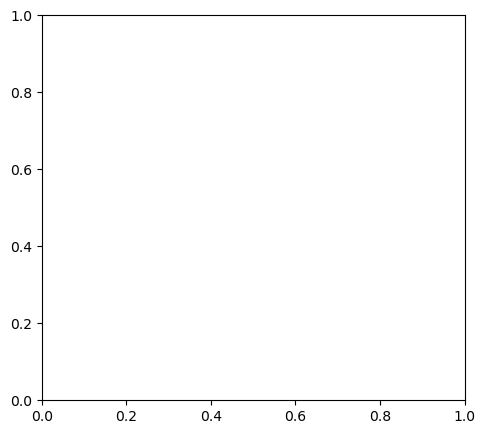

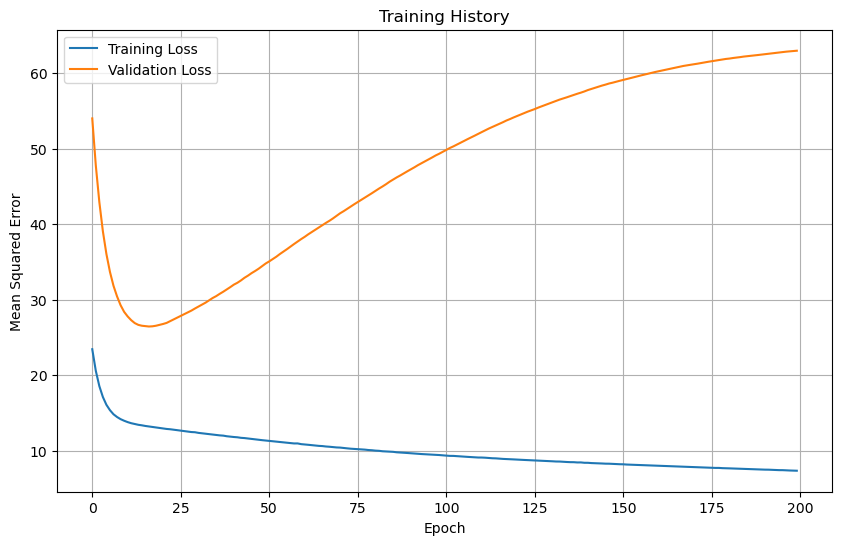

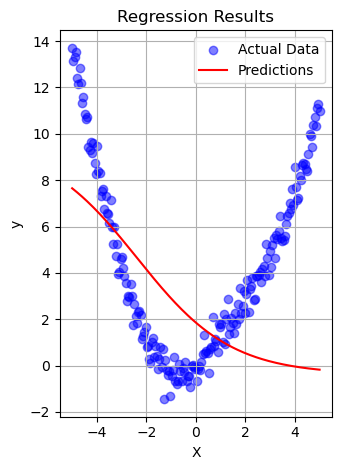

In [1]:
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

class NeuralNetworkRegression:
    def __init__(self, input_size: int, hidden_size: int, learning_rate: float = 0.01):
        # Network architecture parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        # Initialize weights and biases with random values
        self.weights_ih = np.random.randn(input_size, hidden_size) * 0.01
        self.weights_ho = np.random.randn(hidden_size, 1) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, 1))
        
        # Lists to store training history
        self.loss_history: List[float] = []
        self.val_loss_history: List[float] = []

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid function"""
        return x * (1 - x)

    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Forward propagation
        Returns: hidden_layer_output, network_output, hidden_layer_input
        """
        # Hidden layer computations
        hidden_layer_input = np.dot(X, self.weights_ih) + self.bias_hidden
        hidden_layer_output = self.sigmoid(hidden_layer_input)
        
        # Output layer computations
        output_layer_input = np.dot(hidden_layer_output, self.weights_ho) + self.bias_output
        network_output = output_layer_input  # Linear activation for regression
        
        return hidden_layer_output, network_output, hidden_layer_input

    def backward(self, X: np.ndarray, y: np.ndarray, 
                hidden_output: np.ndarray, network_output: np.ndarray,
                hidden_input: np.ndarray) -> None:
        """Backward propagation and weight updates"""
        batch_size = X.shape[0]
        
        # Output layer error
        output_error = network_output - y
        
        # Hidden layer error
        hidden_error = np.dot(output_error, self.weights_ho.T) * self.sigmoid_derivative(self.sigmoid(hidden_input))
        
        # Update weights and biases
        # Output layer updates
        self.weights_ho -= self.learning_rate * np.dot(hidden_output.T, output_error) / batch_size
        self.bias_output -= self.learning_rate * np.mean(output_error, axis=0, keepdims=True)
        
        # Hidden layer updates
        self.weights_ih -= self.learning_rate * np.dot(X.T, hidden_error) / batch_size
        self.bias_hidden -= self.learning_rate * np.mean(hidden_error, axis=0, keepdims=True)

    def mse_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Calculate Mean Squared Error loss"""
        return np.mean((y_true - y_pred) ** 2)

    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
             epochs: int, batch_size: int, 
             X_val: Optional[np.ndarray] = None, 
             y_val: Optional[np.ndarray] = None,
             verbose: bool = True) -> None:
        """Train the neural network"""
        n_samples = X_train.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Mini-batch training
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, n_samples)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Forward pass
                hidden_output, network_output, hidden_input = self.forward(X_batch)
                
                # Backward pass
                self.backward(X_batch, y_batch, hidden_output, network_output, hidden_input)
                
                # Calculate loss
                batch_loss = self.mse_loss(y_batch, network_output)
                epoch_loss += batch_loss * (end_idx - start_idx)
            
            # Calculate average epoch loss
            epoch_loss /= n_samples
            self.loss_history.append(epoch_loss)
            
            # Validation loss
            if X_val is not None and y_val is not None:
                _, val_predictions, _ = self.forward(X_val)
                val_loss = self.mse_loss(y_val, val_predictions)
                self.val_loss_history.append(val_loss)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}")
            elif verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        _, predictions, _ = self.forward(X)
        return predictions

    def plot_loss_history(self) -> None:
        """Plot training and validation loss history"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, label='Training Loss')
        if self.val_loss_history:
            plt.plot(self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    # Generate sample regression data
    np.random.seed(42)
    X = np.linspace(-5, 5, 200).reshape(-1, 1)
    y = 0.5 * X**2 + np.sin(X) + np.random.normal(0, 0.5, X.shape)
    
    # Split data into train and validation sets
    train_size = int(0.8 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    # Normalize input data
    X_mean, X_std = X_train.mean(), X_train.std()
    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std
    
    # Create and train the network
    model = NeuralNetworkRegression(
        input_size=1,
        hidden_size=10,
        learning_rate=0.01
    )
    
    # Train the model
    model.train(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=200,
        batch_size=32,
        verbose=True
    )
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Training history
    plt.subplot(1, 2, 1)
    model.plot_loss_history()
    
    # Predictions vs actual
    plt.subplot(1, 2, 2)
    X_test = (X - X_mean) / X_std  # Normalize test data
    predictions = model.predict(X_test)
    
    plt.scatter(X, y, c='b', label='Actual Data', alpha=0.5)
    plt.plot(X, predictions, 'r-', label='Predictions')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Regression Results')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()